<a href="https://colab.research.google.com/github/fjot/project_8_nlp/blob/main/proyect_8_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 8- NLP - Twitter US Airline Sentiment**





A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [3]:
!pip install contractions

     |████████████████████████████████| 266kB 7.9MB/s 
     |████████████████████████████████| 327kB 13.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85256 sha256=b14859999552b75cd7b60755b9c9d1945daef0d32b4d26a5c677fa63de71e090
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [4]:
import re, string, unicodedata                         
import contractions                                     
from bs4 import BeautifulSoup                           

import numpy as np                                      
import pandas as pd                                     
import nltk                                             

nltk.download('stopwords')                              
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder      
from sklearn.model_selection import train_test_split   
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
from google.colab import drive

#**1. Load the data**
### - Import the libraries
### - load dataset
### - print shape of data
### - data description


In [6]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
project_path = '/content/drive/My Drive/Colab Notebooks/NLP/'

In [8]:
data = project_path + 'Tweets.csv'

In [9]:
data = pd.read_csv(data)

In [10]:
data.shape

(14640, 15)

In [11]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


# **2. Understand of data-columns:**
### - Drop all other columns except “text” and “airline_sentiment”
### - Check the shape of data
### - Print first 5 rows of data

In [13]:
#Drop all other columns except “text” and “airline_sentiment”.
data = data.loc[:14640, ['airline_sentiment', 'text']]

In [14]:
# Check the shape of data
data.shape

(14640, 2)

In [15]:
# Print first 5 rows of data
data.head()                                

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


# **3. Text pre-processing: Data preparation.**

### - Html tag removal
### - Remove the numbers.
### - Removal of Special Characters and Punctuations.
### - Conversion to lowercase.
### - Lemmatize or stemming.
### - Join the words in the list to convert back to text string in the dataframe. 
###- Print first 5 rows of data after pre-processing.




In [16]:
# Html tag removal
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))

In [17]:
# Remove the numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))

In [18]:
# Removal of Special Characters and Punctuations.
def replace_contractions(text):
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))

In [19]:
# Tokenization of data with nltk.word_tokenize
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [20]:
# Remove non_ascii
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words                            

In [21]:
# Transform to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


In [22]:
# Remove the punctuation
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [23]:
# Remove Stopwords
stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

In [24]:
# Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

In [25]:
# Apply the framework and normalize the data
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)

In [26]:
# Print first 5 rows of data after pre-processing.
data.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience ...
2,neutral,virginamerica today must mean need take anothe...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


# **Vectorization**:
### - Use CountVectorizer
### - Use TfidfVectorizer

In [52]:
# CountVectorizer
vectorizer = CountVectorizer(max_features=500)                
data_features = vectorizer.fit_transform(data['text'])

# Convert the data features to array.
data_features = data_features.toarray()                      

In [53]:
# TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500)
data_features_2 = vectorizer.fit_transform(data['text'])

# Convert the data features to array.
data_features_2 = data_features_2.toarray()

In [29]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

In [30]:
# Assigning numerical values
data['airline_sentiment_categorical'] = labelencoder.fit_transform(data['airline_sentiment'])

In [31]:
data.head()

,airline_sentiment,text,airline_sentiment_categorical
0,neutral,virginamerica dhepburn say,1
1,positive,virginamerica plus add commercials experience ...,2
2,neutral,virginamerica today must mean need take anothe...,1
3,negative,virginamerica really aggressive blast obnoxiou...,0
4,negative,virginamerica really big bad thing,0


In [32]:
labels = data['airline_sentiment_categorical']
labels = labels.astype('int')

# **Fit and evaluate model using both type of vectorization.**

In [54]:
# Split data into training and testing set for CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [55]:
model = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = model.fit(X_train, y_train)
print(forest)
print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6905737704918032


In [56]:
# Predict the result for test data using the model built above.
result = forest.predict(X_test)

[[2421  273  120]
 [ 385  420   79]
 [ 166  126  402]]


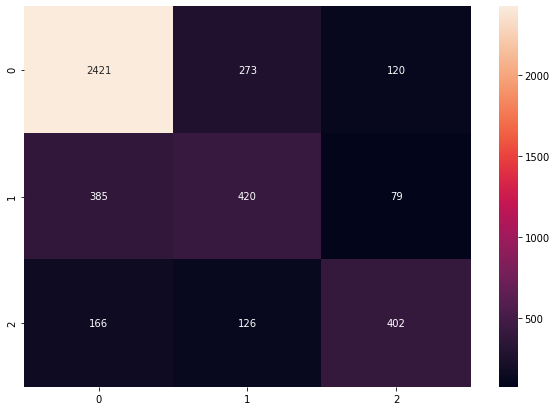

In [57]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, result)
print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## **Insight**:
- 2421 twees were to predict as a negative and they are negative 
- 273 twees were to predict as a negative but they are neutral
- 120 twees were to predict as a negative but they are positive

- 385 tweets were to predict as a neutral but they are negative
- 420 tweets were to predict as a neutral and they are neutral
- 79 tweets were to predict as a neutral but they are positives

- 166 tweets were to predict as a positive but they are negative
- 126 tweets were to predict as a positve but they are neutral
- 402 tweets were to predict as a positive and they are positives


In [58]:
# Split data into training and testing set from TfidfVectorizer
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_features_2, labels, test_size=0.3, random_state=42)

In [59]:
model = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = model.fit(X_train_2, y_train_2)
print(forest)
print(np.mean(cross_val_score(forest, data_features_2, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.698292349726776


In [60]:
result = forest.predict(X_test_2)

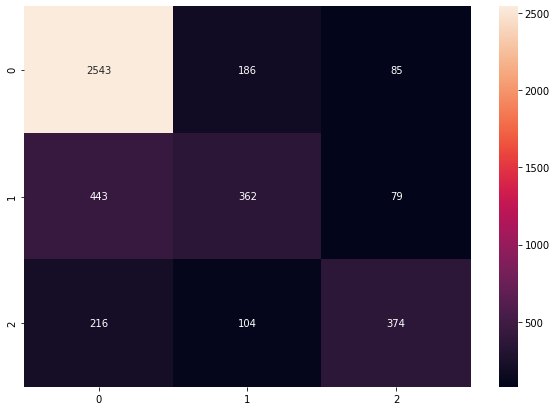

In [61]:
conf_mat = confusion_matrix(y_test_2, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## **Insight**:
- 2543 twees were to predict as a negative and they are negative 
- 186 twees were to predict as a negative but they are neutral
- 85 twees were to predict as a negative but they are positive

- 443 tweets were to predict as a neutral but they are negative
- 362 tweets were to predict as a neutral and they are neutral
- 79 tweets were to predict as a neutral but they are positives

- 216 tweets were to predict as a positive but they are negative
- 104 tweets were to predict as a positve but they are neutral
- 374 tweets were to predict as a positive and they are positives


# **Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset.**

### - Its used dataset which has reviews in text format and their sentiment score on the scale of 0 to 2. 0:negativ , 1:neutral, 2: positive
### - Its used strip_html, remove_numbers, remove_contraction and word_tokenize before Its applied normalzation.
### - It fitted tha data normalized with CountVectorizerand TfidfVectorizer and the generated features converted to array.
### - Its used Label Encoder to transform the 'airline_sentiment' into categorical values.
### - It fitted and evaluated 2 models using both type of vectorization.
### - The accuracy of both models is around 70% but in both cases the number of features could be increased to improve accuracy.
### - Another way to increase accuracy is to use different variations of Pre-processing techniques.
